In [ ]:
# # uncomment if running in colab
# # install the github repo https://github.com/Edogor/GPT_from_scratch.git
# !git clone https://github.com/Edogor/GPT_from_scratch.git
# # change to repo dir and install requirements
# %cd /content/GPT_from_scratch/
# %pip install -r requirements.txt
# # download and prep preprocess data
# !python ./data/clean_nltk_shakespear_data_w_nl.py
# # change to notebooks dir
# %cd /content/GPT_from_scratch/notebooks/
# %pwd .

## imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F    
from torch.optim import AdamW
from torch.optim import ASGD
from torch.amp.grad_scaler import GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from functools import partial

import json
import os

CHECKPOINT_DIR = os.path.join("..", "checkpoints", "nBigram", "hparams_search")
LOG_DIR = os.path.join("..", "logs", "nBigram", "hparams_search")
RESULTS_DIR = os.path.join("..", "results", "nBigram", "hparams_search")

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [2]:
# add parent directory to the path to allow imports
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from neural_bigram import NeuralBigram, ConfigNeuralBigram
from train_mj import train, evaluate, evaluate_ppl, ConfigTrain
from hparam_search import hparams_search_nBigram, HparamsSpaceNBigram
from utils import init_dataloader, WarmupThenCosine, set_seed, count_params, save_checkpoint, load_checkpoint
from bpe_hf import train_bytelevel_bpe, train_and_encode_tokenizer, load_tokenizer, TOK_SPECIAL_TOKENS

## load data

In [3]:
data_dir = "../data/"
# without nl
# train_file = "Shakespeare_clean_train.txt"
# val_file = "Shakespeare_clean_valid.txt"
# test_file = "Shakespeare_clean_test.txt"

# with nl
train_file = "Shakespeare_clean_w_nl_train.txt"
val_file = "Shakespeare_clean_w_nl_valid.txt"
test_file = "Shakespeare_clean_w_nl_test.txt"

train_file = os.path.join(data_dir, train_file)
test_file = os.path.join(data_dir, test_file)
val_file = os.path.join(data_dir, val_file)

with open(train_file, "r", encoding="utf-8") as f:
    train_text = f.read().strip()

with open(val_file, "r", encoding="utf-8") as f:
    val_text = f.read().strip()

with open(test_file, "r", encoding="utf-8") as f:
    test_text = f.read().strip()

print("train text charachters length: ", len(train_text))
print("train text words count: ", len(train_text.split()))
print("train text first 100 chars: ", train_text[:100])

train text charachters length:  883046
train text words count:  158364
train text first 100 chars:  The Tragedy of Antony and Cleopatra


Dramatis Personae



MARK ANTONY
OCTAVIUS CAESAR
M. AEMILIUS L


## define hyperparameters space

In [ ]:
SEED = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# hyperparameters 
# data
BATCH_SIZE = 32
BLOCK_SIZE = 128

# tokenizer
N_MERGES = 200
MIN_FREQ = 2
SPECIAL_TOKENS = TOK_SPECIAL_TOKENS.copy()

#  model
DROPOUT = 0.1
# optimizer
LR = 3e-3
WEIGHT_DECAY = 1e-4
# scheduler
ETA_MIN = 1e-8

# training loop
EPOCHS = 60
ES_PATIENCE = 5
ES_TOLERANCE = 1e-6
GRAD_ACCUM_STEPS = 1
USE_AMP = True if DEVICE == "cuda" else False # IMPORTANT: set to False if training on CPU training 

# checkpoints
EVAL_INTERVAL = 2   # evaluate every n epochs
CKPT_INTERVAL = 10  # save checkpoint every n epochs

# config for training
cfg_train_base = ConfigTrain(device=DEVICE,
                    epochs=EPOCHS, 
                    early_stop_patience=ES_PATIENCE,
                    early_stop_tolerance=ES_TOLERANCE,
                    grad_accum_steps=GRAD_ACCUM_STEPS,
                    # max_grad_norm=data.get("max_grad_norm", 1.0),
                    use_amp=USE_AMP,
                    seed=SEED,
                    eval_interval=EVAL_INTERVAL,
                    ckpt_interval=CKPT_INTERVAL,
                    ckpt_dir=os.path.join(CHECKPOINT_DIR),
                    ckpt_best_filename="best.pt",
                    ckpt_last_filename="last.pt",
                    log_dir=os.path.join(LOG_DIR),
                    )
# config for model
cfg_model_base = ConfigNeuralBigram(
                    vocab_size=N_MERGES+256,
                    dropout=DROPOUT
                    )

cfg_hp_space = HparamsSpaceNBigram(
                            merges=(10, 200, 800,),
                            lr=(3e-4, 3e-3, 3e-2,),
                            dropout=(0.0, 0.3,),
                            lr_scheduler=("cosine_warmup",),
                            )

hps_df_save_path = os.path.join(RESULTS_DIR, f"nBigram_hps_m{len(cfg_hp_space.merges)}"+\
                                f"_lr{len(cfg_hp_space.lr)}_d{len(cfg_hp_space.dropout)}"+\
                                f"_{time.strftime('%y%m%d_%H%M%S')}.csv")

print("device: ", DEVICE)
print(f"Total runs: {cfg_hp_space.num_total_combinations()}")

# log and checkpoint dir and filenames
print("log dir: ", cfg_train_base.log_dir)
print("checkpoint dir: ", cfg_train_base.ckpt_dir)
print("checkpoint best filename: ", cfg_train_base.ckpt_best_filename)
print("checkpoint last filename: ", cfg_train_base.ckpt_last_filename)
print("log dir: ", cfg_train_base.log_dir)
print("hparams search results: ", hps_df_save_path)

device:  cpu
Total runs: 18
log dir:  ../logs/nBigram/hparams_search
checkpoint dir:  ../checkpoints/nBigram/hparams_search
checkpoint best filename:  best.pt
checkpoint last filename:  last.pt
log dir:  ../logs/nBigram/hparams_search
hparams search results:  ../results/nBigram/hparams_search/nBigram_hps_m3_lr3_d2_250827_221608.csv


## run hyperparameter search

In [5]:
hparams_search_df = hparams_search_nBigram(
    hp_space=cfg_hp_space,
    train_text_path=train_file,
    val_text_path=val_file,
    # training base cfg
    base_cfg_train=cfg_train_base,
    # model base cfg
    base_cfg_model=cfg_model_base,
    # tokenizer
    tokenizer_trainer=train_bytelevel_bpe,
    special_tokens=SPECIAL_TOKENS,
    tok_min_frequency=MIN_FREQ,
    # data
    batch_size=BATCH_SIZE,
    block_size=BLOCK_SIZE,
    # lr scheduler
    eta_min=ETA_MIN,
    # I/O
    verbose=False,
)

HParams Search:   0%|          | 0/18 [00:00<?, ?trial/s]

W0826 00:07:26.367000 206119 torch/_dynamo/convert_frame.py:1016] [0/8] torch._dynamo hit config.recompile_limit (8)
W0826 00:07:26.367000 206119 torch/_dynamo/convert_frame.py:1016] [0/8]    function: 'forward' (/home/mj/Documents/GPT_from_scratch/neural_bigram.py:23)
W0826 00:07:26.367000 206119 torch/_dynamo/convert_frame.py:1016] [0/8]    last reason: 0/7: GLOBAL_STATE changed: grad_mode 
W0826 00:07:26.367000 206119 torch/_dynamo/convert_frame.py:1016] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0826 00:07:26.367000 206119 torch/_dynamo/convert_frame.py:1016] [0/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


In [6]:
print(hparams_search_df.columns)
display(hparams_search_df.head())
best = hparams_search_df.iloc[0]
display("Best trial:", best.to_dict())

# save dataframe to CSV
hparams_search_df.to_csv(hps_df_save_path, index=False)

Index(['merges', 'lr', 'dropout', 'weight_decay', 'scheduler', 'vocab_size',
       'model_size', 'val_ppl', 'train_ppl', 'val_loss', 'train_loss',
       'epochs', 'ckpt_best', 'ckpt_last', 'full_config_file', 'run'],
      dtype='object')


,merges,lr,dropout,weight_decay,scheduler,vocab_size,model_size,val_ppl,train_ppl,val_loss,train_loss,epochs,ckpt_best,ckpt_last,full_config_file,run
0,10,0.030,0.0,0.0001,cosine_warmup,270,72900,14.044237,14.063792,2.642229,2.643604,60,../checkpoints/neural_bigram/hparams_search/be...,../checkpoints/neural_bigram/hparams_search/la...,../checkpoints/neural_bigram/hparams_search/hp...,hps_250825_191628_95eac0d6
1,10,0.003,0.0,0.0001,cosine_warmup,270,72900,14.094849,14.124273,2.645809,2.647895,60,../checkpoints/neural_bigram/hparams_search/be...,../checkpoints/neural_bigram/hparams_search/la...,../checkpoints/neural_bigram/hparams_search/hp...,hps_250825_191322_128c276e
2,10,0.030,0.3,0.0001,cosine_warmup,270,72900,14.819916,33.585239,2.696114,3.514087,57,../checkpoints/neural_bigram/hparams_search/be...,../checkpoints/neural_bigram/hparams_search/la...,../checkpoints/neural_bigram/hparams_search/hp...,hps_250825_191734_0f15c2de
3,10,0.003,0.3,0.0001,cosine_warmup,270,72900,15.240481,33.599762,2.723955,3.514519,60,../checkpoints/neural_bigram/hparams_search/be...,../checkpoints/neural_bigram/hparams_search/la...,../checkpoints/neural_bigram/hparams_search/hp...,hps_250825_191431_4df39219
4,200,0.030,0.0,0.0001,cosine_warmup,460,211600,29.543959,28.256927,3.389913,3.341339,60,../checkpoints/neural_bigram/hparams_search/be...,../checkpoints/neural_bigram/hparams_search/la...,../checkpoints/neural_bigram/hparams_search/hp...,hps_250825_192506_64b6746f


'Best trial:'

{'merges': 10,
 'lr': 0.03,
 'dropout': 0.0,
 'weight_decay': 0.0001,
 'scheduler': 'cosine_warmup',
 'vocab_size': 270,
 'model_size': 72900,
 'val_ppl': 14.04423713684082,
 'train_ppl': 14.06379222869873,
 'val_loss': 2.642229379491603,
 'train_loss': 2.643603593498454,
 'epochs': 60,
 'ckpt_best': '../checkpoints/neural_bigram/hparams_search/best_hps_250825_191628_95eac0d6.pt',
 'ckpt_last': '../checkpoints/neural_bigram/hparams_search/last_hps_250825_191628_95eac0d6.pt',
 'full_config_file': '../checkpoints/neural_bigram/hparams_search/hps_250825_191628_95eac0d6_hparams.json',
 'run': 'hps_250825_191628_95eac0d6'}

## results and evaluation

### load results data

In [5]:
# load the dataframe from CSV
# from_hps_file = hps_df_save_path
from_hps_file = os.path.join(RESULTS_DIR, 
                "nBigram_hps_m5_lr3_d3_250827_191850.csv")

hparams_search_df = pd.read_csv(from_hps_file)
display(hparams_search_df.head())

,merges,lr,dropout,weight_decay,scheduler,vocab_size,model_size,val_ppl,train_ppl,val_loss,train_loss,epochs,ckpt_best,ckpt_last,full_config_file,run
0,10,0.030,0.0,0.0001,cosine_warmup,270,72900,14.250536,14.040438,2.656949,2.641942,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_192408_d001ea3c
1,10,0.003,0.0,0.0001,cosine_warmup,270,72900,14.306400,14.103891,2.660707,2.646451,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_192147_0a73b00f
2,10,0.030,0.2,0.0001,cosine_warmup,270,72900,14.526601,25.051655,2.676009,3.220940,55,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_192455_1fd07a43
3,10,0.003,0.2,0.0001,cosine_warmup,270,72900,14.755886,25.132387,2.691642,3.224157,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_192234_f8884b63
4,10,0.030,0.4,0.0001,cosine_warmup,270,72900,15.727795,44.840137,2.755465,3.803104,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_192541_6978c834


### visualize results

In [6]:
from hparam_search import (plot_per_hp_grouped, 
                            plot_interaction_heatmap,
                            plot_perm_importance_hbar,
                            plot_generelization_gap)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


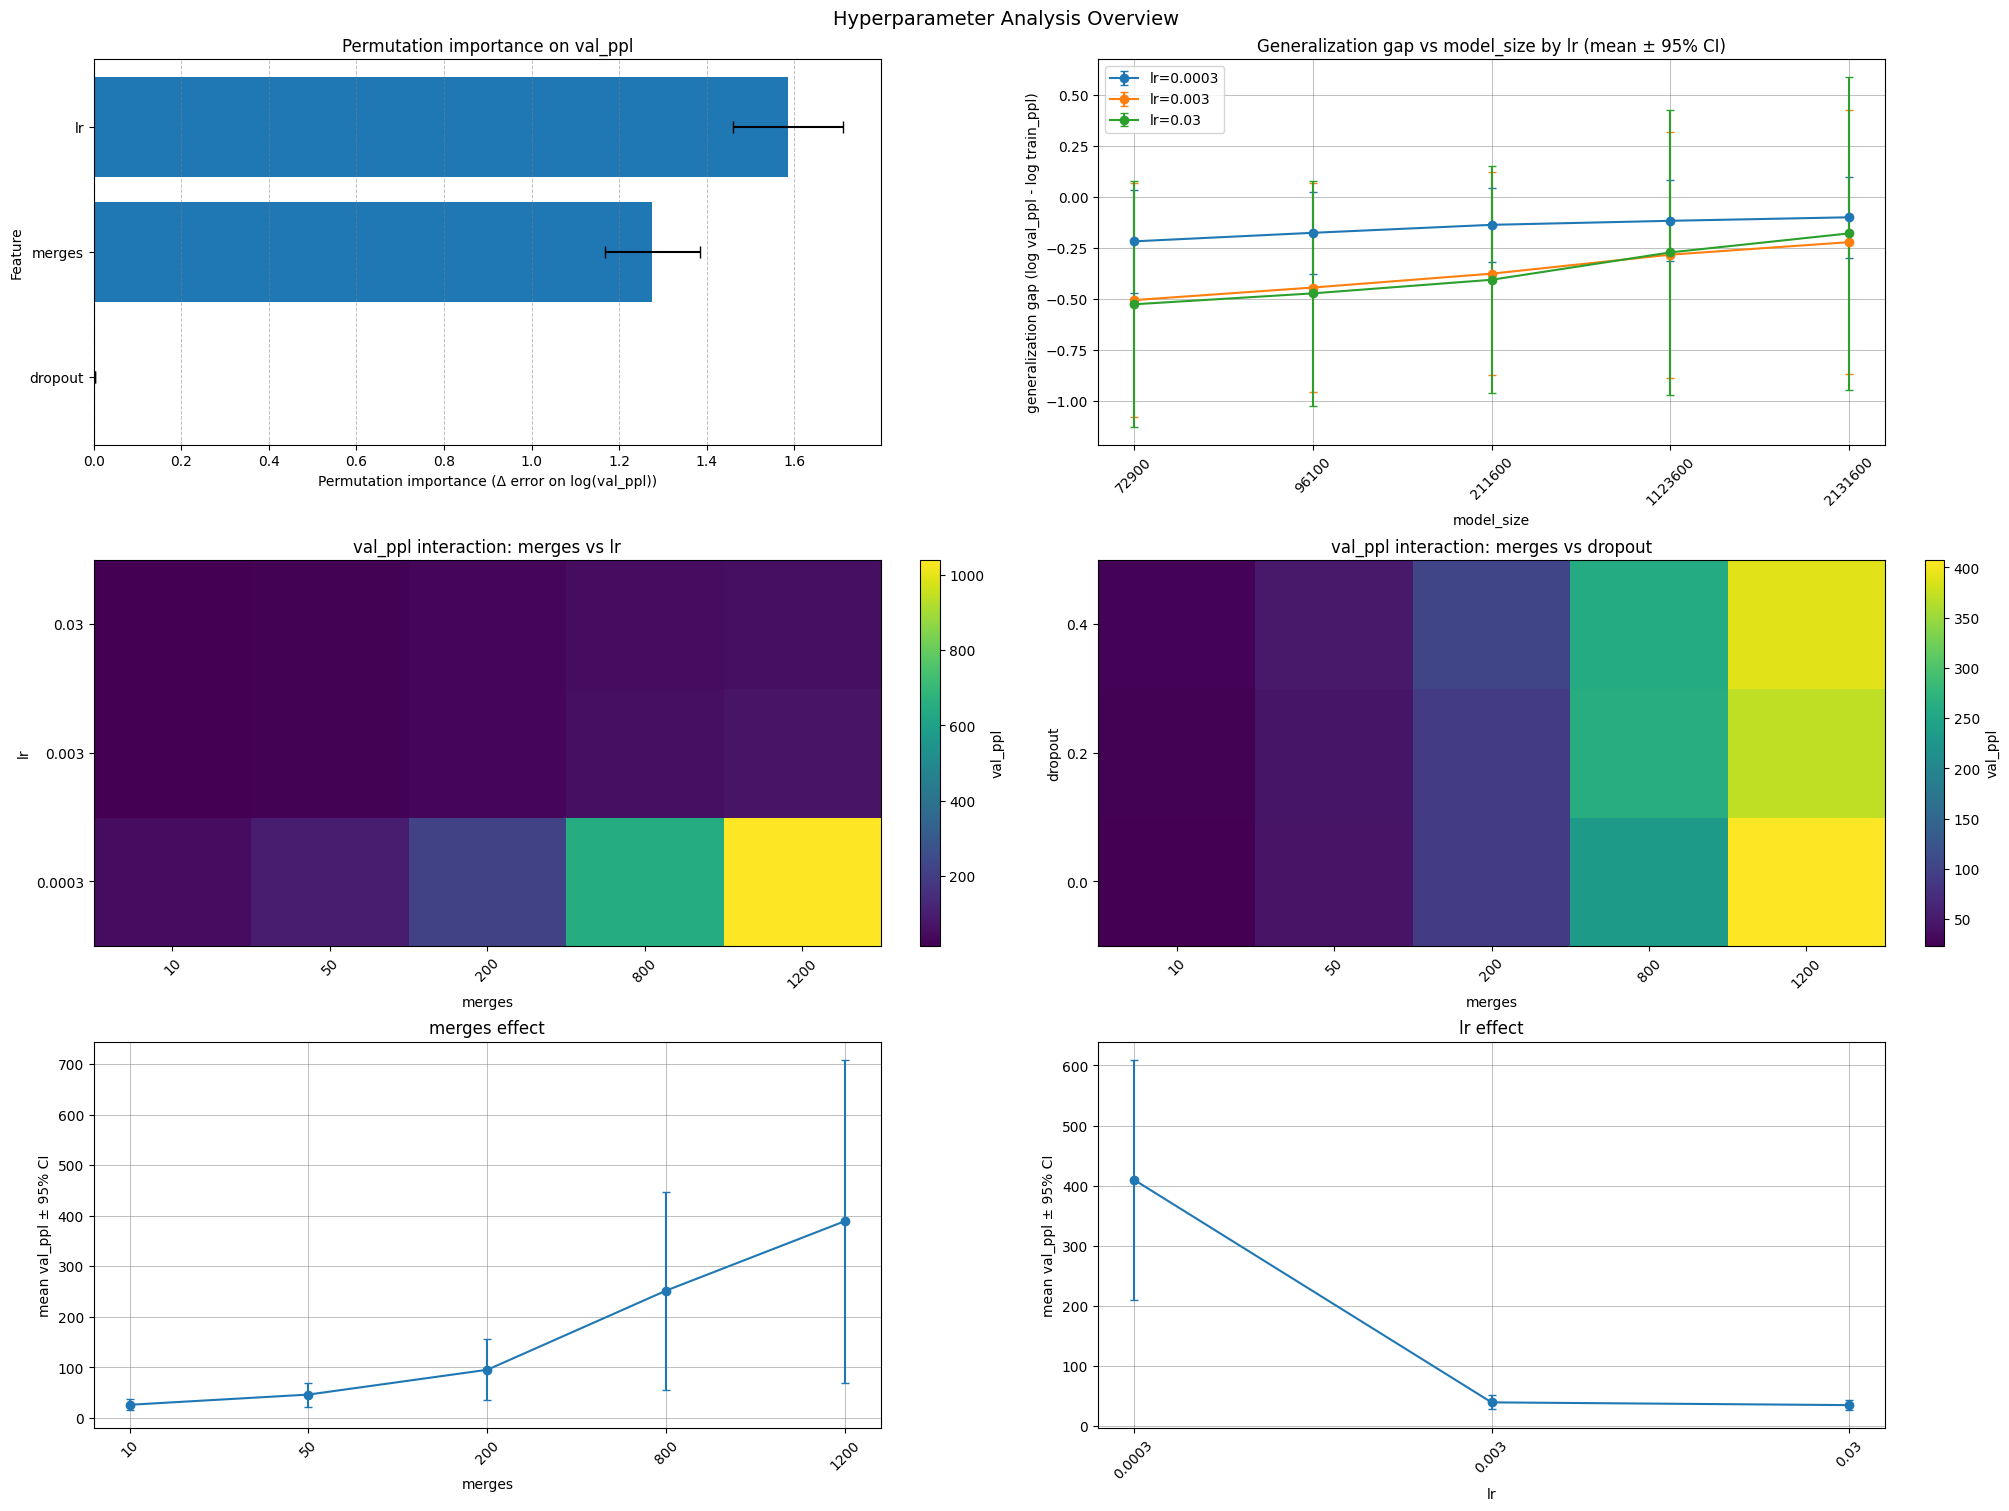

In [7]:
# plot overview of hyperparameter analysis results
savepath = os.path.join(RESULTS_DIR, "nBigram_hparams_analysis_overview.png")
use_log_metric = True
max_groups_lineplots = 5

df = hparams_search_df.copy()

df["log_val_ppl"] = np.log(df["val_ppl"])

# figure & grid
fig, axes = plt.subplots(3, 2, figsize=(20, 15), constrained_layout=True)
axes = axes.flatten()

fig.suptitle("Hyperparameter Analysis Overview", fontsize=14)

# assign axes
ax_perm_imp = axes[0]
ax_gen_gap = axes[1]
ax_heatmap_1 = axes[2]
ax_heatmap_2 = axes[3]
ax_hp_grouped_1 = axes[4]
ax_hp_grouped_2 = axes[5]

# permutation importance
# relevant features
feature_candidates = ["merges", "lr", "dropout"]
features = [c for c in feature_candidates if c in df.columns]
plot_perm_importance_hbar(
    df,
    features,
    metric="val_ppl",  # keep target consistent with your helpers
    title="Permutation importance on val_ppl",
    n_estimators=500,
    n_repeats=30,
    random_state=0,
    ax=ax_perm_imp,
)

# eneralization gap 
plot_generelization_gap(df, hp="model_size", groupby="lr", 
                        use_log=use_log_metric, max_groups=max_groups_lineplots, ax=ax_gen_gap)
# heatmap merges × lr
plot_interaction_heatmap(df, "merges", "lr", metric="val_ppl", ax=ax_heatmap_1)
# heatmap merges × dropout 
plot_interaction_heatmap(df, "merges", "dropout", metric="val_ppl", ax=ax_heatmap_2)
# per-HP grouped: lr by merges
plot_per_hp_grouped(df, "merges", groupby=None, metric="val_ppl", max_groups=max_groups_lineplots, ax=ax_hp_grouped_1)
# per-HP grouped: dropout by merges
plot_per_hp_grouped(df, "lr", groupby=None, metric="val_ppl", max_groups=max_groups_lineplots, ax=ax_hp_grouped_2)

if savepath:
    fig.savefig(savepath)

plt.show()


### generate text from the best model per num merges

In [8]:
# sort results by val_ppl
hparams_seach__sorted = hparams_search_df.sort_values(by="val_ppl").reset_index(drop=True)
print("Best hyperparameters:")
display(hparams_seach__sorted.head(1))

# get best hyperparameters per merges
best_per_merges = hparams_seach__sorted.loc[hparams_seach__sorted.groupby("merges")["val_ppl"].idxmin()].reset_index(drop=True)
best_per_merges = best_per_merges.sort_values(by="merges").reset_index(drop=True)
print("Best hyperparameters per merges:")
display(best_per_merges)

Best hyperparameters:


,merges,lr,dropout,weight_decay,scheduler,vocab_size,model_size,val_ppl,train_ppl,val_loss,train_loss,epochs,ckpt_best,ckpt_last,full_config_file,run
0,10,0.03,0.0,0.0001,cosine_warmup,270,72900,14.250536,14.040438,2.656949,2.641942,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_192408_d001ea3c


Best hyperparameters per merges:


,merges,lr,dropout,weight_decay,scheduler,vocab_size,model_size,val_ppl,train_ppl,val_loss,train_loss,epochs,ckpt_best,ckpt_last,full_config_file,run
0,10,0.03,0.0,0.0001,cosine_warmup,270,72900,14.250536,14.040438,2.656949,2.641942,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_192408_d001ea3c
1,50,0.03,0.0,0.0001,cosine_warmup,310,96100,20.789402,20.297733,3.034675,3.010509,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_193034_b1a0d2d2
2,200,0.03,0.0,0.0001,cosine_warmup,460,211600,31.037220,28.088709,3.442939,3.335368,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_193551_bc63915a
3,800,0.03,0.0,0.0001,cosine_warmup,1060,1123600,46.215153,31.990595,3.933539,3.465442,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_193955_3afb8909
4,1200,0.03,0.0,0.0001,cosine_warmup,1460,2131600,53.998936,32.045918,4.139673,3.467170,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_194338_927efebb


In [10]:
test_runs = []
# load the best model for each merges
for merges in best_per_merges["merges"].unique():
    best_row = best_per_merges[best_per_merges["merges"] == merges].iloc[0]
    run_name = best_row["run"]
    ckpt_path = os.path.join(best_row['ckpt_best'])
    # if best ckpt does not exist, use last
    if not os.path.exists(ckpt_path):
        print(f"## WARNING ## Best checkpoint {ckpt_path} does not exist, using last checkpoint instead.")
        ckpt_path = os.path.join(best_row['ckpt_last'])
        if not os.path.exists(ckpt_path):
            print(f"## WARNING ## Last checkpoint {ckpt_path} also does not exist, skipping this run.")
            continue

    print(f"Loading best model for merges={merges} from {ckpt_path}")
    full_cfg_file = best_row['full_config_file']
    full_cfg_ = json.load(open(os.path.join(full_cfg_file), "r"))
    # device = full_cfg_["training"]["device"]
    device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"Loaded config from {full_cfg_file}")
    ckpt = load_checkpoint(ckpt_path, map_location=device, weights_only=False)
    
    # tokenizer 
    tokenizer = load_tokenizer(os.path.join(full_cfg_['tokenizer']['path']))
    encode = partial(tokenizer.encode, add_special_tokens=False)
    pad_id = tokenizer.token_to_id(SPECIAL_TOKENS.get("bos", "<bos>"))
    decode = tokenizer.decode
    vocab_size = tokenizer.get_vocab_size()
    
    # data
    # train_ids = encode(train_text).ids
    # val_ids = encode(val_text).ids
    test_ids = encode(test_text).ids

    test_loader = init_dataloader(
        test_ids, 
        block_size=full_cfg_['data']["block_size"],
        batch_size=full_cfg_['data']["batch_size"],
        train=False,
        shuffle=False,
    )
    # model
    model = NeuralBigram(ConfigNeuralBigram(**full_cfg_['model']['cfg']))
    model.load_state_dict(ckpt["model"])
    model.to(device)

    # get optimizer dynamicly from his class name
    optimizer_class = getattr(torch.optim, full_cfg_['optimizer']['type'])
    optimizer = optimizer_class(model.parameters(), lr=full_cfg_['optimizer']['lr'])
    optimizer.defaults.update({k:v for k,v in full_cfg_['optimizer']['defaults'].items()}) # update optimizer defaults with full config
    # get scheduler dynamicly from his class name
    if full_cfg_['lr_scheduler']['type'] == "WarmupThenCosine":
        lr_scheduler_class = WarmupThenCosine
        lr_scheduler = lr_scheduler_class(optimizer, warmup_steps=full_cfg_['lr_scheduler']['state_dict']['warmup_steps'],
                                          T_max=full_cfg_['lr_scheduler']['state_dict']['T_max'],
                                          eta_min=full_cfg_['lr_scheduler']['state_dict']['eta_min'],)
    else:
        lr_scheduler_class = getattr(torch.optim.lr_scheduler, full_cfg_['lr_scheduler']['type'])
        lr_scheduler = lr_scheduler_class(optimizer)
        lr_scheduler.load_state_dict({k:v for k,v in full_cfg_['lr_scheduler'].items() if k != 'name'})  # update scheduler state dict with full config

    # get scaler dynamicly from his class name
    scaler_class = getattr(torch.amp, full_cfg_['scaler']['type'])
    scaler = scaler_class(enabled=full_cfg_['training']['cfg']['use_amp'])

    # evaluate the loaded model
    model.eval()
    test_avg_loss = evaluate(model, test_loader, device=device)
    test_ppl = np.exp(test_avg_loss)
    
    
    # generate from the loaded model
    context = " ".join(test_text.split()[:3])
    context_ids = encode(context).ids
    context_ids = torch.tensor(context_ids, dtype=torch.long, device=device).unsqueeze(0)  # (1, T_in)

    print("Generating from model with:")
    print(f"merges={merges}, lr={full_cfg_['optimizer']['lr']:.6e}, dropout={full_cfg_['model']['cfg']['dropout']}")
    print("model parameters count: ", full_cfg_['model']['model_size'])
    print(f"Test PPL: {test_ppl:.2f}, val PPL: {best_row['val_ppl']:.2f}, train PPL: {best_row.get('train_ppl', None)}\n")
    print("\n>>>> ", decode(context_ids[0].tolist()), "\n", "-"*20, "\n")
    
    top_k = 20
    temperature = 1.2
    # rep_penalty = 1.2
    # print(f"\nsample with top_k={top_k}, t={temperature}, penalty={rep_penalty}\n")
    print(f"\nsample with top_k={top_k}, t={temperature}\n")
    model.eval()
    generated_ids = model.generate(context_ids, max_new_tokens=50, temperature=temperature, top_k=top_k)
    generated_ids = generated_ids[:, context_ids.size(1):] # remove context 

    print("<<<< ", decode(generated_ids[0].tolist()), "\n")
    print("-"* 120 , "\n")

    test_runs.append({
        "test_loss": test_avg_loss,
        "test_ppl": test_ppl,
        **best_row.to_dict(),
        "merges": merges,
        "lr": full_cfg_['optimizer']['lr'],
        "dropout": full_cfg_['model']['cfg']['dropout'],
        "model_size": full_cfg_['model']['model_size'],
        "run_name": run_name,
        "ckpt_path": ckpt_path,
        "generated_text_sample": decode(generated_ids[0].tolist()),
        "context": context,
    })
test_runs = pd.DataFrame(test_runs)
test_runs = test_runs.sort_values(by="test_ppl").reset_index(drop=True)
display(test_runs)

Loading best model for merges=10 from ../checkpoints/nBigram/hparams_search/best_hps_250827_192408_d001ea3c.pt
Loaded config from ../checkpoints/nBigram/hparams_search/hps_250827_192408_d001ea3c_hparams.json
Generating from model with:
merges=10, lr=3.000000e-02, dropout=0.0
model parameters count:  72900
Test PPL: 13.78, val PPL: 14.25, train PPL: 14.040437698364258


>>>>   shall the lovers 
 -------------------- 


sample with top_k=20, t=1.2

<<<<  el ndy I ue g idir d shaingrainthes ighis ingadalinn me,  

------------------------------------------------------------------------------------------------------------------------ 

Loading best model for merges=50 from ../checkpoints/nBigram/hparams_search/best_hps_250827_193034_b1a0d2d2.pt
Loaded config from ../checkpoints/nBigram/hparams_search/hps_250827_193034_b1a0d2d2_hparams.json
Generating from model with:
merges=50, lr=3.000000e-02, dropout=0.0
model parameters count:  96100
Test PPL: 19.60, val PPL: 20.79, train PPL: 20.297733

,test_loss,test_ppl,merges,lr,dropout,weight_decay,scheduler,vocab_size,model_size,val_ppl,...,train_loss,epochs,ckpt_best,ckpt_last,full_config_file,run,run_name,ckpt_path,generated_text_sample,context
0,2.623155,13.779122,10,0.03,0.0,0.0001,cosine_warmup,270,72900,14.250536,...,2.641942,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_192408_d001ea3c,hps_250827_192408_d001ea3c,../checkpoints/nBigram/hparams_search/best_hps...,el ndy I ue g idir d shaingrainthes ighis inga...,shall the lovers
1,2.975728,19.603897,50,0.03,0.0,0.0001,cosine_warmup,310,96100,20.789402,...,3.010509,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_193034_b1a0d2d2,hps_250827_193034_b1a0d2d2,../checkpoints/nBigram/hparams_search/best_hps...,"s,\nIfor ass a meneadas.\n\nThe wit, lirigerad...",shall the lovers
2,3.299772,27.106445,200,0.03,0.0,0.0001,cosine_warmup,460,211600,31.037220,...,3.335368,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_193551_bc63915a,hps_250827_193551_bc63915a,../checkpoints/nBigram/hparams_search/best_hps...,and my luevery come to dry of again\nCAses th...,shall the lovers
3,3.501104,33.152022,800,0.03,0.0,0.0001,cosine_warmup,1060,1123600,46.215153,...,3.465442,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_193955_3afb8909,hps_250827_193955_3afb8909,../checkpoints/nBigram/hparams_search/last_hps...,the glessench'd\nWe of this?\nBENCE\nHARI wil...,shall the lovers
4,3.538396,34.411690,1200,0.03,0.0,0.0001,cosine_warmup,1460,2131600,53.998936,...,3.467170,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_194338_927efebb,hps_250827_194338_927efebb,../checkpoints/nBigram/hparams_search/last_hps...,",\nWhich was the matter in a pale.\n\n\nOPHELI...",shall the lovers


In [11]:
# save test text outputs to txt file
test_performance_file = os.path.join(RESULTS_DIR, "nBigram_test_results_gen_text.txt")
with open(test_performance_file, "w", encoding="utf-8") as f:
    f.write(f"Test performance of best models per merges from hparams search:\n")
    f.write(f"test generation format:\n")
    f.write(f">>>> <context>\n {'-' *20}\n<<<< <generated_text>\n")
    f.write("="*120 + "\n\n")
    for idx, run in test_runs.iterrows():
        f.write(f"merges={run['merges']}, lr={run['lr']:.6e}, dropout={run['dropout']}\n")
        f.write(f"model parameters count: {run['model_size']}\n")
        f.write(f"Test PPL: {run['test_ppl']:.2f}, val PPL: {run['val_ppl']:.2f}, train PPL: {run.get('train_ppl', None)}\n")
        f.write(f"\n>>>> {run['context']}\n{'-'*20}\n")
        f.write(f"<<<< {run['generated_text_sample']}\n")
        f.write(f"{'-' * 120}\n")
    print(f"Saved test performance to {test_performance_file}")
    f.close()

Saved test performance to ../results/nBigram/hparams_search/nBigram_test_results_gen_text.txt


### performance on test set

,test_ppl,val_ppl,train_ppl,merges,lr,dropout,model_size,test_loss,weight_decay,scheduler,...,train_loss,epochs,ckpt_best,ckpt_last,full_config_file,run,run_name,ckpt_path,generated_text_sample,context
0,13.779122,14.250536,14.040438,10,0.03,0.0,72900,2.623155,0.0001,cosine_warmup,...,2.641942,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_192408_d001ea3c,hps_250827_192408_d001ea3c,../checkpoints/nBigram/hparams_search/best_hps...,el ndy I ue g idir d shaingrainthes ighis inga...,shall the lovers
1,19.603897,20.789402,20.297733,50,0.03,0.0,96100,2.975728,0.0001,cosine_warmup,...,3.010509,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_193034_b1a0d2d2,hps_250827_193034_b1a0d2d2,../checkpoints/nBigram/hparams_search/best_hps...,"s,\nIfor ass a meneadas.\n\nThe wit, lirigerad...",shall the lovers
2,27.106445,31.037220,28.088709,200,0.03,0.0,211600,3.299772,0.0001,cosine_warmup,...,3.335368,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_193551_bc63915a,hps_250827_193551_bc63915a,../checkpoints/nBigram/hparams_search/best_hps...,and my luevery come to dry of again\nCAses th...,shall the lovers
3,33.152022,46.215153,31.990595,800,0.03,0.0,1123600,3.501104,0.0001,cosine_warmup,...,3.465442,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_193955_3afb8909,hps_250827_193955_3afb8909,../checkpoints/nBigram/hparams_search/last_hps...,the glessench'd\nWe of this?\nBENCE\nHARI wil...,shall the lovers
4,34.411690,53.998936,32.045918,1200,0.03,0.0,2131600,3.538396,0.0001,cosine_warmup,...,3.467170,60,../checkpoints/nBigram/hparams_search/best_hps...,../checkpoints/nBigram/hparams_search/last_hps...,../checkpoints/nBigram/hparams_search/hps_2508...,hps_250827_194338_927efebb,hps_250827_194338_927efebb,../checkpoints/nBigram/hparams_search/last_hps...,",\nWhich was the matter in a pale.\n\n\nOPHELI...",shall the lovers


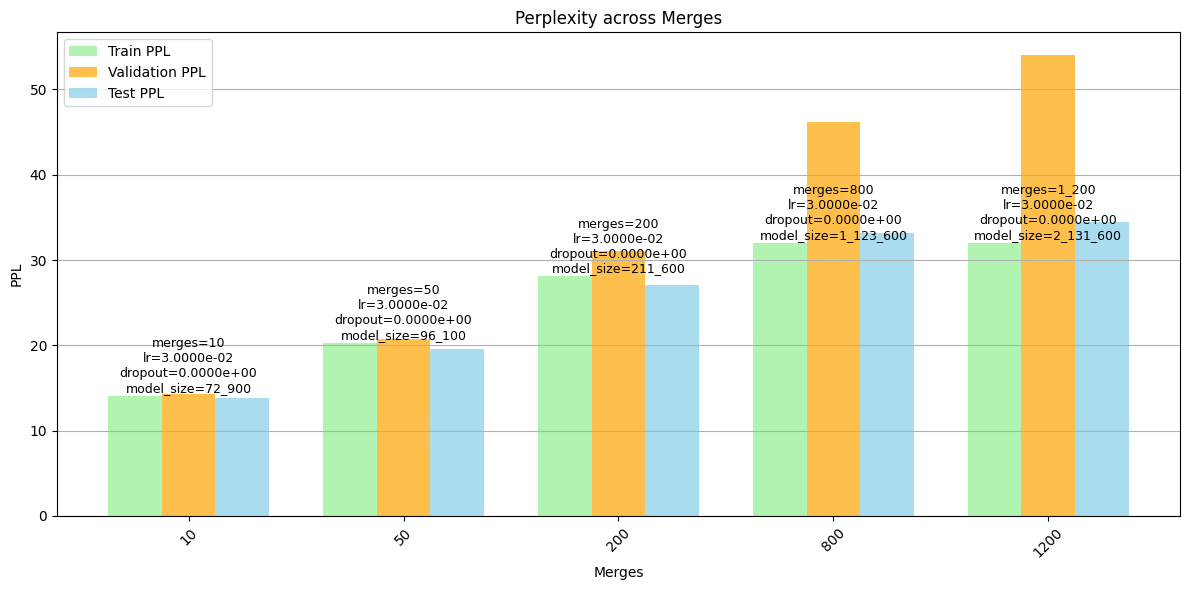

In [12]:
# reorder columns
front_columns = ['test_ppl', 'val_ppl', 'train_ppl', 'merges', 'lr', 'dropout', 'model_size']
test_runs = test_runs[front_columns + [c for c in test_runs.columns if c not in front_columns]]
display(test_runs)
# save test results to csv
test_runs.to_csv(os.path.join(RESULTS_DIR, "nBigram_test_results.csv"), index=False)

x = np.arange(len(best_per_merges['merges']))   
width = 0.25                 

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, best_per_merges['train_ppl'], width, label="Train PPL", color="lightgreen", alpha=0.7)
ax.bar(x,         best_per_merges['val_ppl'],   width, label="Validation PPL", color="orange", alpha=0.7)
ax.bar(x + width, test_runs['test_ppl'],  width, label="Test PPL", color="skyblue", alpha=0.7)

# annotate the bars with the values of front_columns without the test_ppl, val_ppl, train_ppl
for i, row in best_per_merges.iterrows():
    annotations = [f"{col}={row[col]:.4e}" if isinstance(row[col], float) else f"{col}={row[col]:_}"
                   for col in front_columns if col not in ['test_ppl', 'val_ppl', 'train_ppl']]
    annotation_text = "\n".join(annotations)
    ax.text(i, best_per_merges['train_ppl'][i] + 0.1, annotation_text, ha='center', va='bottom', fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(best_per_merges['merges'], rotation=45)
ax.set_title("Perplexity across Merges")
ax.set_xlabel("Merges")
ax.set_ylabel("PPL")
ax.grid(True, axis='y')
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "nBigram_test_results_ppl.png"), dpi=150, bbox_inches="tight")
plt.show()